# **Pontificia Universidad Javeriana**
# **Taller de Algoritmos genéticos**
**Hecho por:**

Juan Diego Reyes

Mariana Díaz

Isaac Janica


<img src="https://i.ytimg.com/vi/qiKW1qX97qA/maxresdefault.jpg"/>



### **Reporte: Entrenamiento de un algoritmo genético para solución de un laberinto**

#### **Introducción**

Los **algoritmos genéticos** en *machine learning* son técnicas de optimización inspiradas en la evolución biológica. Se basan en los principios de **selección natural, cruce y mutación** para encontrar soluciones óptimas o cercanas al óptimo (optimales) en problemas complejos. Cada posible solución se representa como un “individuo” dentro de una “población”, y su calidad se mide mediante una función de evaluación o *fitness*. A lo largo de varias generaciones, las soluciones más adecuadas se combinan y modifican para generar nuevas poblaciones con mejores resultados. Estos algoritmos se usan especialmente cuando el espacio de búsqueda es grande o no se conoce bien la estructura del problema, como en la optimización de hiperparámetros o el diseño de redes neuronales.

---

#### **Variables**

Para el entrenamiento del algoritmos se va a utilizar el siguiente laberinto:

<img src="maze.png"/>

El problema a resolver cuenta con 3 componentes:
1. Una entrada, dónde comienza el punto de partida del algoritmo.
2. Un laberinto constituido por por los caminos blancos y las paredes negras.
3. Un salida, el punto final en dónde el algoritmo termina la ejecución.



# Instalación e Importe de librerías

In [1]:
!pip install deap

In [2]:
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython import display
import random
from deap import base, creator, tools, algorithms

# Var Globales

Aqui se definen las variables como el laberinto y los movimientos que puede tomar el modelo:
- (0,1) -> moverse arriba
- (0,-1) -> moverse abajo
- (-1,0) -> moverse a la izquierda
- (1,0) -> moverse a la derecha

In [3]:
# Var Globales

# Movimientos posibles
#              (arriba, abajo, izquierda, derecha)
MOVIMIENTOS = [(0, 1), (0, -1), (-1, 0), (1, 0)]


# Crear un laberinto de 10x10

laberinto = np.zeros((20, 20))

inicio = (0, 0)
salida = (0, 19)
for i in range(1, 19, 4):

  laberinto[0:19, i] = 1

for i in range(3, 20, 4):

  laberinto[1:20, i] = 1



# Fun generales
Aqui se encuentran las funciones como:
- mostrar_laberinto()
- mover(posición, movimiento)


In [4]:
def mostrar_laberinto():
    ax = plt.gca()
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))
    #ax.set_xticklabels(np.arange(0, 10, 1));
    #ax.set_yticklabels(np.arange(0, 10, 1));
    ax.imshow(laberinto.T, cmap='binary')
    plt.gca().invert_yaxis()
    plt.plot(inicio[0], inicio[1], "ro", label="Inicio")
    plt.plot(salida[0], salida[1], "go", label="Salida")
    plt.grid(True, which='both')
    plt.legend()
    plt.show()


def mover(pos, movimiento):
    # Realiza el movimiento (x, y)
    nueva_pos = (pos[0] + movimiento[0], pos[1] + movimiento[1])

    # Verificar si está dentro de los límites y no es una pared
    if 0 <= nueva_pos[0] < laberinto.shape[0] and 0 <= nueva_pos[1] < laberinto.shape[1]:
        if laberinto[nueva_pos] == 0:  # No es una pared
            return nueva_pos
    return pos  # Si no es un movimiento válido, quedarse en el mismo lugar

def mostrar_ruta_pasos(individuo, s=0.01,laberinto=None, inicio=None, salida=None, grid=False):
    generacion = individuo if isinstance(individuo[0], list) else [individuo]

    NOMBRE_MOVIMIENTOS = ['arriba', 'abajo', 'izquierda', 'derecha']
    #pos = inicio
    #camino = [pos]
    #nombre_camino = ['nada']
    #numero_movimiento = ['-']

    #limpia el anterior plot
    plt.clf()

    fig, ax = plt.subplots()
    #ax.invert_yaxis()
    for ind in generacion:
        pos = inicio
        camino = [pos]
        for i, movimiento in enumerate(ind):
            pos = mover(pos, MOVIMIENTOS[movimiento])

            camino.append(pos)
            #nombre_camino.append(NOMBRE_MOVIMIENTOS[movimiento])
            #numero_movimiento.append(movimiento)

            # Convert to NumPy array for plotting
            camino_np = np.array(camino)


            # Plot the path up to the current step
            ax.clear()
            if grid:
              ax.set_xticks(np.arange(0, laberinto.shape[1], 1))
              ax.set_yticks(np.arange(0, laberinto.shape[1], 1))
              #ax.set_xticklabels(np.arange(0, 10, 1));
              #ax.set_yticklabels(np.arange(0, 10, 1));
              ax.grid(grid, which='both')
            ax.set_ylim(-1, laberinto.shape[1])
            ax.set_xlim(-1, laberinto.shape[0])
            ax.imshow(laberinto.T, cmap='binary')
            ax.plot(camino_np[:, 0], camino_np[:, 1], "r-")
            ax.plot(-1, -1, "ro", label=f"{i+1}")
            ax.plot(inicio[0], inicio[1], "bo", label="Inicio")  # Start point
            ax.plot(salida[0], salida[1], "go", label="Salida")   # End point
            #ax.plot(pos_anterior[0], pos_anterior[1], "bo", label=f"pos-ant {pos_anterior}", alpha=0.6)   # End point
            ax.plot(pos[0], pos[1], "bx", label=f"pos {pos}")   # End point
            plt.xlabel("Eje X")
            plt.ylabel("Eje Y")

            ax.legend()

            # Update the display

            display.clear_output(wait=True)
            display.display(fig)

            time.sleep(s)
    plt.close(fig)  # Close the figure to prevent further updates
    #plt.show()  # Keep the final plot displayed

def mostrar_ruta_terminada(individuo, laberinto=None, inicio=None, salida=None, grid=False):
    pos = inicio
    camino = [pos]
    for movimiento in individuo:
        pos = mover(pos, MOVIMIENTOS[movimiento])
        camino.append(pos)

    # Convert to NumPy array for plotting
    camino_np = np.array(camino)

    plt.clf()
    fig, ax = plt.subplots()
    if grid:
      ax.set_xticks(np.arange(0, laberinto.shape[1], 1))
      ax.set_yticks(np.arange(0, laberinto.shape[1], 1))
      #ax.set_xticklabels(np.arange(0, 10, 1));
      #ax.set_yticklabels(np.arange(0, 10, 1));
      ax.grid(grid, which='both')
    ax.set_ylim(-1, laberinto.shape[1])
    ax.set_xlim(-1, laberinto.shape[0])
    ax.imshow(laberinto.T, cmap='binary')
    ax.plot(camino_np[:, 0], camino_np[:, 1], "r-")
    ax.plot(inicio[0], inicio[1], "bo", label="Inicio")  # Start point
    ax.plot(salida[0], salida[1], "go", label="Salida")   # End point
    ax.plot(pos[0], pos[1], "bx", label=f"pos {pos}")   # End point
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")

    ax.legend()
    plt.show()
    plt.close(fig)  # Close the figure to prevent further updates


# Correr

## Función Aptitud (Fitness)
Esta función se encarga de seleccionar las soluciones que son más aptas (mayor fitness) para el problema

Para el entrenamiento del modelo se tiene de manera teórica el siguiente comportamiento al modificar los hiperparámetros de las funciones:
1. **Tamaño de población:** define cuántos individuos (soluciones candidatas) existen en cada generación. Las poblaciones pequeñas tienen la ventaje de evolucionan rápido y tienen un menor consumo de CPU (esto es especialmente importante si no se cuenta con un procesador que tenga una baja capacidad para paralelizar los procesos), en cambio las población gandes permiten una mayor diversidad de soluciones, hay un mejor conocimiento del espacio de búsqueda y el algoritmo es menos propenso a estancamientos. Por otro lado, las desventajas de una población pequeñas es que tienen menos diversidad y tienen un mayor riesgo de estancamiento, ahora, las desventajas de las poblaciones grandes son que cada generación nueva se vuelve marginalmente más costosa de evaluar y requiere una mayor cantidad de tiempo (o capacidad de cómputo) para entrenar.
2. **Cantidad de generaciones**: una generación representa un ciclo en dónde se hacen los siguientes pasos: selección, cruce, mutación y evaluación. El tener pocas generaciones permite una evolución rápida y es ideal cuando el espacio de búsqueda es pequeño, sin embargo puede detenerse antes de encontrar las soluciones óptimas y quedarse con aquellas que son optimales (se acercan más no son la óptima). En este sentido, si se tienen muchas generaciones se pueden resolver problemas más complejos dónde se requiere una mayor exploración a largo plazo, es decir, que permite un mayor refinamiento de la solución a cambio de un mayor tiempo de entrenamiento.
3. **Cruce:** se encarga de mezclar las partes de dos individuos para generar nuevos. El propósito es recombinar caracterísitcas exitosas para la siguiente generación. Una tasa de cruce alta explora más el espacio de soluciones pero puede hacer que el modelo pierda/ignore las buenas soluciones por el alto de valor de este parámetro. Un tasa baja de esta variable se traduce en una mayor estabilidad del modelo por lo que hay menos recombinación y esto resultar en una menor diversidad que puede llevar a un posible estancamiento.
4. **Mutacioń:** A diferencia del cruce, el cuál mezcla caracterísiticas existentes en los individuos, las mutaciones son cambios aleatorios que tienen como función mantner la diversidad y evitar que la población sea la misma/igual en todos sus individuos. Un alto valor para esta variable aumenta la exploración al tener un mayor nivel de aleatoriedad, pero esto puede desestabilizar el aprendizaje si el valor es excesiva, por otro lado, una tasa muy baja mantiene la estabilidad, es decir, hay una mejor exploración de las soluciones buenas pero con el riesgo de converger/estancarse prematuramente.

In [5]:
def evaluar_individuo(individual):
    pos = inicio
    esquina = inicio
    recompensa_salida = 1

    for i in range(len(individual)):
        pos_anterior = pos
        pos = mover(pos, MOVIMIENTOS[individual[i]])

        if pos[1] > pos_anterior[1]:
            esquina = pos

    
    penalizacion_esquina = 500 - abs(esquina[0] - pos[0]) 

    # Recompensar avance en Y (cuanto más cerca esté de la salida en Y, mejor)
    recompensa_y = (salida[1] - pos[1]) * 1000

    # Recompensar llegar a la salida
    if pos == salida:
        recompensa_salida = 0
    else:
        recompensa_salida = 1



    # Fitness total (menor es mejor)
    fitness = (recompensa_y + penalizacion_esquina) * recompensa_salida

    return (fitness,)


# Crear la estructura del algoritmo genético
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizar la distancia
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_move", random.randint, 0, len(MOVIMIENTOS)-1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_move, n=2000) # 1000 movimientos
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluar_individuo)


## Ejecucion

In [6]:
# Crear la población inicial
pop = toolbox.population(n=1000)  # 100 individuos

# Ejecutar el algoritmo genético
resultados, log = algorithms.eaSimple(pop, toolbox, cxpb=0.4, mutpb=0.05, ngen=25, verbose=False)

<Figure size 640x480 with 0 Axes>

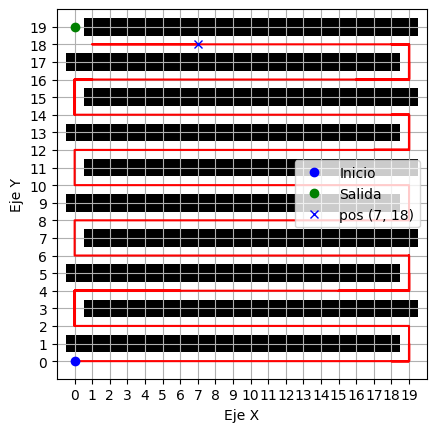

In [7]:
mostrar_ruta_terminada(resultados[0], laberinto=laberinto, inicio=inicio, salida=salida, grid=True)

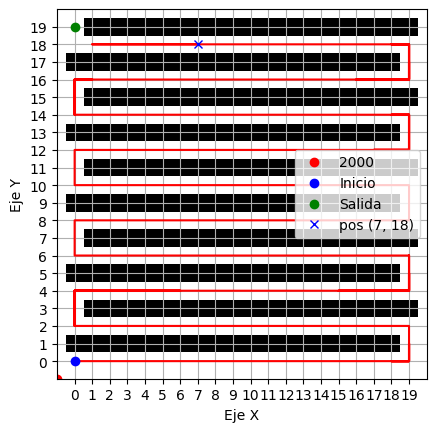

<Figure size 640x480 with 0 Axes>

In [8]:
mostrar_ruta_pasos(resultados[0], laberinto=laberinto, inicio=inicio, salida=salida, grid=True, s=0)

# Ver proceso

# Ejecucion 2

<Figure size 640x480 with 0 Axes>

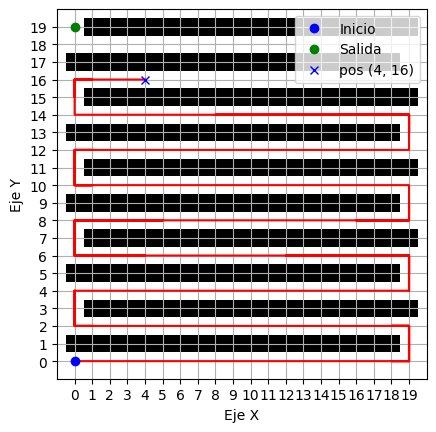

In [9]:
from deap import tools
# Variables para el registro de la evolución
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

logbook = tools.Logbook()

# Crear la población inicial
pop = toolbox.population(n=100)  # 100 individuos

# Ejecutar el algoritmo genético
resultados, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.5, ngen=50,stats=stats, verbose=False)

# Encontrar el mejor individuo
mejor_individuo = tools.selBest(pop, 1)#[0]
mostrar_ruta_terminada(mejor_individuo[0], laberinto=laberinto, inicio=inicio, salida=salida, grid=True)

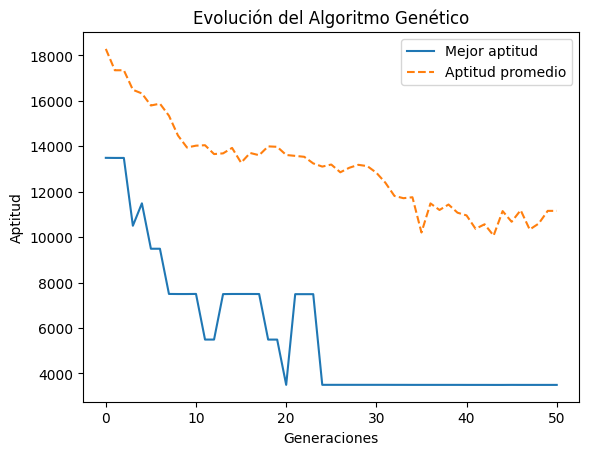

In [10]:
# Extraer las estadísticas de cada generación
generaciones = logbook.select("gen")
minimos = logbook.select("min")
promedios = logbook.select("avg")

# Graficar la evolución
import matplotlib.pyplot as plt

plt.plot(generaciones, minimos, label="Mejor aptitud")
plt.plot(generaciones, promedios, label="Aptitud promedio", linestyle="--")
plt.xlabel("Generaciones")
plt.ylabel("Aptitud")
plt.title("Evolución del Algoritmo Genético")
plt.legend()
plt.show()

# ¿Cómo medimos la **eficiencia** del algoritmo genético (AG)?

Cuando decimos “eficiencia”, en realidad estamos preguntando: **¿cuánto trabajo le toma al AG conseguir una buena solución?**. 


## Qué tiene sentido medir y por qué

- **Tiempo total (segundos)**: al final del día, lo que nos importa es *cuánto tarda* en darnos una ruta útil. Es la métrica más “real” de coste.
- **Evaluaciones = población × generaciones**: el AG trabaja evaluando individuos; ese producto nos da un buen aprox del **esfuerzo computacional**.
- **Mejor fitness y su curva por generación**: no solo quiero saber dónde termina, también **cómo llega** (convergencia rápida vs. lenta, si se estanca, etc.).
- **Éxito (llegó a la salida)**: si el *fitness=0*, lo logró. Es la forma más clara de decir “sirvió”.
- **Generación de convergencia**: momento a partir del cual **ya casi no mejora**, útil para detectar **rendimientos decrecientes** (seguir iterando ya no aporta).

La idea es simple: si con el *mismo esfuerzo* (mismas evaluaciones) una configuración llega antes, mejora más y tiene más éxito, **es más eficiente**.



=== A) Población (presupuesto ~5000 evals) ===
         pop |         ngen |         cxpb |        mutpb |        evals |    t_prom(s) |    best_prom | conv_gen_prom |      exito_%
---------------------------------------------------------------------------------------------------------------------
          50 |          100 |          0.5 |          0.1 |         5000 |        7.109 |       6822.0 |         19.3 |            0
         100 |           50 |          0.5 |          0.1 |         5000 |        6.532 |      6496.67 |           26 |            0
         200 |           25 |          0.5 |          0.1 |         5000 |        6.146 |       2166.0 |         14.3 |            0

=== B) Generaciones (pop=100) ===
         pop |         ngen |         cxpb |        mutpb |        evals |    t_prom(s) |    best_prom | conv_gen_prom |      exito_%
---------------------------------------------------------------------------------------------------------------------
         100 |

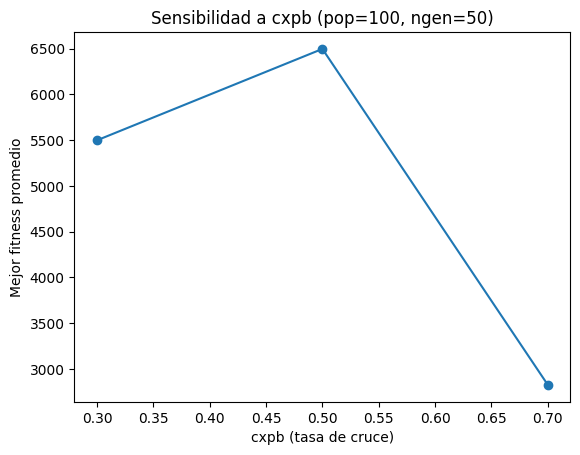

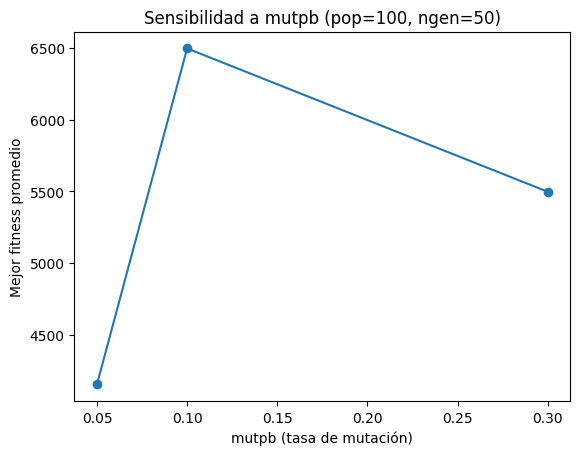

In [24]:

# MEDICIONES DE EFICIENCIA (no modifica tu código base)

import time, random
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt

# stats (si no existía)
try:
    stats
except NameError:
    from deap import tools
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)


def corre_trial(seed, pop_size, cxpb, mutpb, ngen):
    """
    Corre UNA vez el AG con esos parámetros y devuelve métricas.
    """
    random.seed(seed)
    pop = toolbox.population(n=pop_size)

    t0 = time.time()
    resultados, logbook = algorithms.eaSimple(
        pop, toolbox,
        cxpb=cxpb, mutpb=mutpb, ngen=ngen,
        stats=stats, verbose=False
    )
    dt = time.time() - t0  # tiempo total (s)

    gens = logbook.select("gen")
    mins = logbook.select("min")
    best_fit = mins[-1] if mins else float("inf")

    # Convergencia: última gen con mejora >= 1% vs gen anterior
    conv_gen = gens[-1] if not mins else max(
        [g for i, g in enumerate(gens) if i == 0 or mins[i] <= 0.99 * mins[i-1]],
        default=gens[-1]
    )

    return {
        "dt": dt,
        "evaluaciones": pop_size * ngen,
        "best": float(best_fit),
        "conv_gen": int(conv_gen),
        "exito": int(best_fit == 0),
        "gens": gens,
        "mins": mins,
        "params": dict(pop=pop_size, cxpb=cxpb, mutpb=mutpb, ngen=ngen),
    }

def resumen_promedio(trials):
    """Promedia varias corridas (seeds distintas)."""
    return {
        "t_prom(s)": round(mean(t["dt"] for t in trials), 3),
        "evals": trials[0]["evaluaciones"] if trials else None,
        "best_prom": round(mean(t["best"] for t in trials), 2),
        "conv_gen_prom": round(mean(t["conv_gen"] for t in trials), 1),
        "exito_%": round(100 * mean(t["exito"] for t in trials), 1),
    }

def corre_promedio(k, pop_size, cxpb, mutpb, ngen):
    """Ejecuta k corridas y devuelve (resumen, corridas_crudas)."""
    trials = [corre_trial(seed, pop_size, cxpb, mutpb, ngen) for seed in range(k)]
    resumen = resumen_promedio(trials)
    resumen.update({"pop": pop_size, "ngen": ngen, "cxpb": cxpb, "mutpb": mutpb})
    return resumen, trials

def print_tabla(title, rows):
    """Tabla de texto simple para comparar configuraciones."""
    print(f"\n=== {title} ===")
    headers = ["pop","ngen","cxpb","mutpb","evals","t_prom(s)","best_prom","conv_gen_prom","exito_%"]
    print(" | ".join(h.rjust(12) for h in headers))
    print("-"*13*len(headers))
    for r in rows:
        print(" | ".join(str(r[h]).rjust(12) for h in headers))


# EXPERIMENTOS (cambia SOLO PARÁMETROS)

K = 3  # repeticiones por configuración (ajusta según tiempo)

# A) Población con presupuesto ~constante (~5000 evals)
exp_pop = []
for pop_size, ngen in [(50,100), (100,50), (200,25)]:
    r,_ = corre_promedio(K, pop_size=pop_size, cxpb=0.5, mutpb=0.1, ngen=ngen)
    exp_pop.append(r)

# B) Generaciones (pop=100)
exp_ngen = []
for ngen in [25, 50, 100]:
    r,_ = corre_promedio(K, pop_size=100, cxpb=0.5, mutpb=0.1, ngen=ngen)
    exp_ngen.append(r)

# C) Cruce (pop=100, ngen=50)
exp_cx = []
for cx in [0.3, 0.5, 0.7]:
    r,_ = corre_promedio(K, pop_size=100, cxpb=cx, mutpb=0.1, ngen=50)
    exp_cx.append(r)

# D) Mutación (pop=100, ngen=50)
exp_mut = []
for mut in [0.05, 0.10, 0.30]:
    r,_ = corre_promedio(K, pop_size=100, cxpb=0.5, mutpb=mut, ngen=50)
    exp_mut.append(r)

# ---- imprime tablas ----
print_tabla("A) Población (presupuesto ~5000 evals)", exp_pop)
print_tabla("B) Generaciones (pop=100)", exp_ngen)
print_tabla("C) Cruce (pop=100, ngen=50)", exp_cx)
print_tabla("D) Mutación (pop=100, ngen=50)", exp_mut)

# ---- gráficas rápidas ----
plt.figure()
plt.plot([r["cxpb"] for r in exp_cx], [r["best_prom"] for r in exp_cx], marker="o")
plt.xlabel("cxpb (tasa de cruce)"); plt.ylabel("Mejor fitness promedio")
plt.title("Sensibilidad a cxpb (pop=100, ngen=50)")
plt.show()

plt.figure()
plt.plot([r["mutpb"] for r in exp_mut], [r["best_prom"] for r in exp_mut], marker="o")
plt.xlabel("mutpb (tasa de mutación)"); plt.ylabel("Mejor fitness promedio")
plt.title("Sensibilidad a mutpb (pop=100, ngen=50)")
plt.show()



# **Conclusiones**

Es falso pensar que es más probable llegar a la solución si se aumenta la población. Esto se evidenció en el caso en dónde se aumentó el número a 5000, 40000 individuos más que el utilizado en el código actual, y no se logró un resultado satisfactorio sino que este se quedó estancado varios niveles debajo de la salida:

<img src="5000.png"/>

Aumentando la mutación (de 0.1 a 0.3) se ve como la teoría si se cumple dado que hubo un estancamiento prematuro:

<img src="03.png"/>

Por el otro lado reducir la mutación a la mitad (de 0.1 a 0.05) no se ve afectado que el algoritmo llegue al objetivo:

<img src="001.png"/>

Al reducir las generaciones a la mitad muestra que con este número no se llega al objetivo:


<img src="13.png"/>

En cambio al aumentar las generaciones se logra trazar la ruta que llega al objetivo:

<img src="50.png"/>

Al aumentar el nivel de cruce de 0.5 a 0.7 se puede evidencia como no se llega al camino que logra el objetivo:

<img src="07.png"/>

Sin embargo, el reducir de 0.5 a 0.3 tampoco genera que haya una mejoría, sin embargo, si se puede evidenciar como el reducir el valor de esta variable no aleja tanto al algoritmo como lo es un aumento:

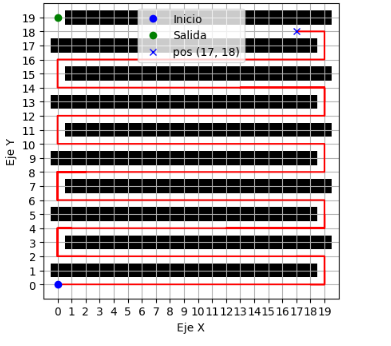

## Conclusión 

**Qué entendemos por eficiencia aquí:** con el mismo “presupuesto” (evaluaciones ≈ población × generaciones), una configuración es más eficiente si **alcanza menor fitness** (mejor solución) **sin aumentar el costo** en tiempo/computación.

**Lo que muestran tus resultados:**

- **Población vs. generaciones (≈5.000 evaluaciones):**  
  A mayor **diversidad inicial** (población 200) y menos generaciones (25), el algoritmo logra un **fitness mucho menor** que con poblaciones más pequeñas y más generaciones. En el laberinto esto sugiere que vale más explorar **mejor** desde el arranque que “refinar” durante muchos ciclos.

- **Más generaciones (pop=100):**  
  Aumentar `ngen` **sí mejora** el fitness, pero con **rendimientos decrecientes**: el salto de 25→50 generaciones es claro; de 50→100 mejora menos por el **mismo costo extra** (tiempo crece casi lineal con `pop × ngen`).


- **Mutación (`mutpb`):**  
  **Mutación baja (0.05)** funcionó mejor que 0.10 y 0.30. Mantiene diversidad **sin romper** soluciones parciales; con tasas altas se pierde estabilidad y la calidad baja.

 
Con un presupuesto fijo, el algoritmo fue **más eficiente** cuando priorizó **diversidad inicial** (población grande) y evita **que se aleje menos** del objetivo(cxpb≈0.5), manteniendo **mutación baja** (≈0.05). Aumentar generaciones ayuda pero llega un punto en que **cuesta más de lo que mejora**. Si se necesitara alcanzar la salida exacta, bastaría con **subir `ngen`** manteniendo esa combinación, asumiendo más tiempo de cómputo.

**Parámetros recomendados (como punto de partida eficiente):**  
`pop ≈ 200`, `ngen 25–50`, `cxpb ≈ 0.5`, `mutpb ≈ 0.05`.